In [1]:
# mount the google drive locally
from google.colab import drive
drive.mount('/content/gdrive')
PATH_DRIVE = "/content/gdrive/My Drive/CrossLingual_embeddings/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# All imports 
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from collections import Counter
import io
import pickle

import collections
import string
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from gensim.utils import lemmatize

import keras
from keras.datasets import imdb
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, LSTM
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [0]:
# All paths 
PATH_IMDB_TRAIN = PATH_DRIVE + "Imdb_train.csv"
PATH_IMDB_TEST = PATH_DRIVE + "Imdb_test.csv"

PATH_CORPUS_CINE = PATH_DRIVE + "CorpusCine.csv"

PATH_MUSE_EN = PATH_DRIVE + "wiki.multi.en.vec"
PATH_MUSE_ES = PATH_DRIVE + "wiki.multi.es.vec"

PATH_WEIGHTS = PATH_DRIVE+"model_e10_with_muse.h5"

PATH_DATA = PATH_DRIVE + "data/"

In [0]:
# function to save objects with pickle
def save_obj(obj, name ):
    with open(PATH_DRIVE+ name + '.pkl', 'wb') as f:
      pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)

# function to load objects with pickle
def load_obj(name ):
    with open(PATH_DRIVE+ name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Load data

In [0]:
cols = ["review","label"]

In [0]:
# English Imdb corpus
df = pd.read_csv(PATH_IMDB_TRAIN,header=None, names=cols)
df_test = pd.read_csv(PATH_IMDB_TEST,header=None, names=cols)
df = df.append(df_test)

In [0]:
# Spanish corpus
df_es = pd.read_csv(PATH_CORPUS_CINE,header=None, names=cols)
df_es_save = pd.read_csv(PATH_CORPUS_CINE,header=None, names=cols)

In [8]:
# number of elements
print(df["label"].count()," english reviews")
print(df_es["label"].count()," spanish reviews")

50000  english reviews
2275  spanish reviews


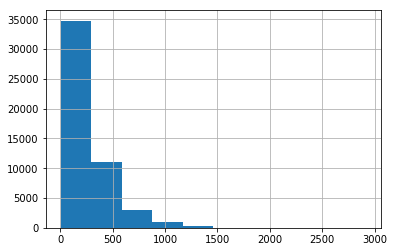

count    50000.00000
mean       279.13746
std        207.65861
min          8.00000
25%        151.00000
50%        209.00000
75%        339.00000
max       2909.00000
dtype: float64

In [9]:
# Analysis of english reviews
reviews_len = [len(word_tokenize(x)) for x in df.review]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

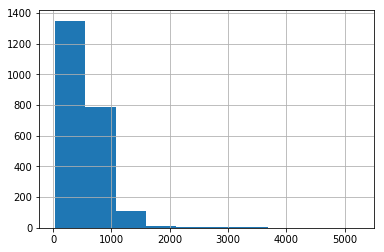

count    2275.000000
mean      572.864176
std       336.653609
min        26.000000
25%       367.000000
50%       492.000000
75%       686.500000
max      5247.000000
dtype: float64

In [10]:
# Analysis of spanish reviews
reviews_len = [len(word_tokenize(x)) for x in df_es.review]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

# Spanish Preprocessing

Special preprocessing steps for the spanish reviews to handle the unknowns characters issues.

In [11]:
# example of one review
df_es.review[0]

'Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que\n        podr�an ser m�s corrosivos.\n    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser\n        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en\n        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an\n        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y\n        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo\n        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que\n        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n\n        c�mica merecedora de

In [12]:
# remove line breaks
del_jump = lambda x: x.replace('\n','')
df_es['review'] = df_es['review'].apply(del_jump)
df_es.review[0]

'Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que        podr�an ser m�s corrosivos.    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n        c�mica merecedora de una sonrisa.Caf� 

In [13]:
# example of one unknown char
unknown_char = df_es.review[0][39]
unknown_char

'�'

In [14]:
# number of unknown char in first review
count = 0
for i in  df_es.review[2]:
  if i==unknown_char:
    count+=1
count

105

In [0]:
# store the number of uknown char by review for the error analysis
l_spanish_char = []
for review in df_es["review"]:
  count = 0
  for i in  review:
    if i==unknown_char:
      count+=1
  l_spanish_char.append(count)

In [0]:
# delete unknown char 
table = collections.defaultdict(lambda: None)
table.update({
    ord(' '):' '
    })
table.update(dict(zip(map(ord,string.ascii_uppercase), string.ascii_lowercase)))
table.update(dict(zip(map(ord,string.ascii_lowercase), string.ascii_lowercase)))
table.update(dict(zip(map(ord,string.digits), string.digits)))

convert_char = lambda x: x.translate(table,)

In [17]:
#try in the first review
print(df_es.review[0])
print(df_es.review[0].translate(table,))

Malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que        podr�an ser m�s corrosivos.    Al entrar al cine s�lo cabe una pregunta: �ser� tan mala como parece? Y al salir s�lo una respuesta: pudo ser        peor. �Ojo! Esto no quiere decir, ni mucho menos, que sea buena. Ni siquiera es mediocre. Pero se queda en        malilla, torpona, facilona, simple, vac�a y otra serie de adjetivos que nunca son de halago, pero que podr�an        ser m�s corrosivos.Del argumento no hace falta ni hablar. Cuatro treinta�eros buscan su lugar en el mundo, y        todo gira, l�gicamente, en torno a las mujeres. Que si yo quiero casarme, que si a m� me han dejado, que si yo        no me como un rosco, que si yo soy un lig�n pero no encuentro el amor. en fin, cuatro situaciones m�s vistas que        el tebeo, que se mezclan sin gracia ni arte y que s�lo de vez en cuando son capaces de ofrecer alguna situaci�n        c�mica merecedora de una sonrisa.Caf� s

In [18]:
df_es['review'] = df_es['review'].apply(convert_char)
df_es.review[0]

'malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que        podran ser ms corrosivos    al entrar al cine slo cabe una pregunta ser tan mala como parece y al salir slo una respuesta pudo ser        peor ojo esto no quiere decir ni mucho menos que sea buena ni siquiera es mediocre pero se queda en        malilla torpona facilona simple vaca y otra serie de adjetivos que nunca son de halago pero que podran        ser ms corrosivosdel argumento no hace falta ni hablar cuatro treintaeros buscan su lugar en el mundo y        todo gira lgicamente en torno a las mujeres que si yo quiero casarme que si a m me han dejado que si yo        no me como un rosco que si yo soy un lign pero no encuentro el amor en fin cuatro situaciones ms vistas que        el tebeo que se mezclan sin gracia ni arte y que slo de vez en cuando son capaces de ofrecer alguna situacin        cmica merecedora de una sonrisacaf solo o con ellas ser otra de esas pelculas que en dos

# Preprocessing

## Tokenize — Encode the words

In [0]:
# funciton to clean one review
# return : the tokenized reviews
def clean(sentence):
  
  # lowercase
  sentence = sentence.lower()
  
  # punctuation
  sentence = ''.join([c for c in sentence if c not in punctuation])

  # tokenize
  tokens = word_tokenize(sentence)
  
  return tokens

In [0]:
# clean all reviews and create vocabularies
# return :
# - cleaned_rev : cleaned dataset
# - vocab_to_int : vocabulary mapping all word to an id
# - vocab_to_word : vocabulary mapping all id to a word
def preprocessing(df):
  
  cleaned_rev = []
  count = Counter()
  for review in df["review"]:
#     print(review)
    rev = clean(review)
    cleaned_rev.append(rev)
    count.update(rev)
   
  vocab_to_int = {w:i for i, (w,c) in enumerate(count.most_common())}
  
  vocab_to_word = {i:w for (w,i) in vocab_to_int.items()}
    
  return cleaned_rev, vocab_to_int, vocab_to_word

In [0]:
# preprocess the english corpus
cleaned_rev, vocab_to_int, vocab_to_word = preprocessing(df)

In [0]:
# preprocess the spanish corpus
es_cleaned_rev, es_vocab_to_int, es_vocab_to_word = preprocessing(df_es)

In [23]:
# first three most common spanish words
list(es_vocab_to_int.items())[:3]

[('de', 0), ('que', 1), ('la', 2)]

In [24]:
# first three most common english words
list(vocab_to_int.items())[:3]

[('the', 0), ('and', 1), ('a', 2)]

# Embeddings

## load

In [0]:
# function to load the embeddings
def load_vec(emb_path, nmax):
    '''
    INPUT:
    emb_path: path of the txt file where the word embeddings are
    nmax: maxium number of word embeddings you want to load (I guess that
    the words are ordered from more frequent to least frequent)
    
    OUTPUT:
    embedings: array of dimensions words(nmax) x embedding dimensions (300)
    id2word: dictionary id (keys) word(values)
    word2id: dictionary word (keys) id(values)
    '''
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [0]:
nmax = 50000 #max number of embeddings (max 50_000)
src_embeddings, src_id2word, src_word2id = load_vec(PATH_MUSE_EN, nmax) # english embeddings
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(PATH_MUSE_ES, nmax) # spanish embeddings

In [27]:
print("dim english MUSE emb: ", src_embeddings.shape)
print("dim spanish MUSE emb: ", tgt_embeddings.shape)

dim english MUSE emb:  (50000, 300)
dim spanish MUSE emb:  (50000, 300)


## Update Embeddings Indexing

In [28]:
# get the common words between our imdb corpus and the english embeddings
list_src = list(src_word2id.keys())
list_imdb = list(vocab_to_int.keys())
list_common = []
c=0
for word in list_imdb:
  if word in list_src:
    list_common.append(word)
  else :
    c += 1
print("missing : {}%".format((c/len(list_imdb)*100)))

missing : 80.29778507877357%


In [0]:
# create vocabularies for english corpus
voc_to_id = {w:i for i,w in enumerate(list_common)}
voc_to_word = {i:w for i,w in enumerate(list_common)}

In [0]:
# load the vocabularies from memory
voc_to_id = load_obj("en_voc_to_id" )
voc_to_word = {i:w for (w,i) in voc_to_id.items()}

In [0]:
# get the common words with embeddings
voc_emb_id={}
wordsno=[]
for i, word in voc_to_word.items():
    try:
        src_word2id[word]          
        voc_emb_id[word] = i
    except KeyError:
        wordsno.append(word)
        pass

In [0]:
nb_words = 300 # number of dimension for each word
ordered_emb = np.zeros((len(voc_to_id), nb_words)) # init all embeddings to zeros vectors

In [33]:
# order the embeddings according to the english corpus vocabulary
for word, index in voc_emb_id.items():
    en_id = src_word2id[word]
    ordered_emb[index] = src_embeddings[en_id][:nb_words]
print(ordered_emb.shape)

(35741, 300)


In [34]:
# check that the indexing by matching words with older embeddings
print(src_id2word[2])
for i, emb in enumerate(ordered_emb):
  if emb[0] == src_embeddings[2][0]:
      print(vocab_to_word[i])

the
the


## Update spanish embeddings

In [0]:
# This commented code is use to generate the spanish corpus vocabularies
# As it takes a long time to process, the vocabularies has been saved to a pickle file
# and load directly in the next block

# ---

# print(len(list(es_vocab_to_int.items())))

# print(es_vocab_to_int.keys())
# print(es_vocab_to_int["historia"])
# print(tgt_word2id["historia"])
# emb_es_hist = tgt_embeddings[tgt_word2id["historia"]]

# list_w = ['historia', 'que', 'la', 'y']
# list_emb = [tgt_embeddings[tgt_word2id[i]] for i in list_w]

# def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
#     print("Nearest neighbors of \"%s\":" % word)
#     word2id = {v: k for k, v in src_id2word.items()}
#     word_emb = src_emb[word2id[word]]
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-K:][::-1]
#     for i, idx in enumerate(k_best):
#       print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
# #       print(idx)

# def get_closest(word_emb, src_emb, tgt_emb):
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-1:][::-1]
#     return k_best[0]

# nb_features = 300

# en_emb_50 = np.zeros((len(src_embeddings), nb_features))
# for i,emb in enumerate(src_embeddings):
#   en_emb_50[i] = emb[:nb_features]
  
# es_emb_50 = np.zeros((len(tgt_embeddings), nb_features))
# for i,emb in enumerate(tgt_embeddings):
#   es_emb_50[i] = emb[:nb_features]
  
# ord_emb_50 = np.zeros((len(ordered_emb), nb_features))
# for i,emb in enumerate(ordered_emb):
#   ord_emb_50[i] = emb[:nb_features]

# get_nn("historia", en_emb_50, src_id2word, es_emb_50, tgt_id2word, K=1)

# for w in list_w:
#   emb = tgt_embeddings[tgt_word2id[w]]
# #   print("{} :".format(w))#
#   #closest_word(voc_emb_id, ordered_emb, vocab_to_word, emb)))
#   get_nn(w, es_emb_50, tgt_id2word, ord_emb_50, voc_to_word, K=1)
# #   print(get_closest(emb, tgt_embeddings, ordered_emb))

# es_voc_to_id = {}
# miss=[]
# for i,word in enumerate(es_vocab_to_int.keys()):
#   if not i%300:
#     print("{}% : {}% missing".format( (i/len(es_vocab_to_int.keys()))*100, ((len(miss)+1)/(i+1)*100)))
#   try : 
#     emb = es_emb_50[tgt_word2id[word]]
#     es_voc_to_id[word] = get_closest(emb,es_emb_50, ord_emb_50)
#   except KeyError:
#     miss.append(word)
#     pass

# save_obj(es_voc_to_id, "es_voc_to_id_300" )
# save_obj(voc_to_id, "en_voc_to_id_300" )

In [0]:
# load the vocabularies from memory 
es_voc_to_id = load_obj("es_voc_to_id" )
es_voc_to_word = {i:w for (w,i) in es_voc_to_id.items()}

In [37]:
# index spanish reviews
es_reviews_int = []
for review in es_cleaned_rev:
    r = [es_voc_to_id[w] for w in review if w in es_voc_to_id.keys()]
    es_reviews_int.append(r)
print (es_reviews_int[0:3])

[[570, 6156, 1, 97, 211, 3, 14269, 10, 108, 22, 3, 17, 10, 9957, 1486, 1562, 2191, 1562, 18, 1302, 758, 1407, 9957, 17, 320, 13, 180, 1, 1562, 740, 758, 3312, 8917, 9957, 241, 828, 831, 1045, 469, 1437, 1619, 71, 336, 10, 2558, 48, 1619, 1118, 5, 1488, 17, 61, 2659, 6, 570, 6156, 1, 97, 211, 3, 14269, 10, 108, 22, 3, 17, 10, 9957, 1486, 13301, 1045, 156, 537, 1619, 1038, 666, 1431, 1250, 272, 6, 0, 187, 1, 2271, 2973, 6, 13161, 4, 125, 365, 10, 42, 2893, 174, 10, 42, 4, 3837, 68, 73, 2423, 10, 42, 2893, 1045, 68, 13, 2, 10, 42, 2893, 15273, 2, 17, 1045, 2383, 0, 109, 6, 761, 666, 1109, 1486, 2708, 10, 0, 10, 61, 3768, 198, 12246, 1619, 523, 1, 10, 3, 274, 6, 49, 22, 464, 3, 1395, 96, 3, 758, 60, 38, 14, 92, 9957, 97, 3, 125, 10, 6, 106, 8755, 3459, 1562, 6033, 2932, 0, 1957, 3, 2, 1890, 3, 149, 3, 1, 0, 0, 2807, 212, 24772, 17, 9077, 17, 1045, 17, 9077, 1619, 17, 24772, 61, 15906, 1562, 18, 14, 0, 413, 3, 10, 125, 666, 1887, 1, 125, 666, 3555, 10, 31, 125, 61, 151, 5, 320, 198, 7103, 1

In [0]:
# store all labels in a list
es_labels = []
for label in df_es["label"]:
    es_labels.append(label)

# Indexing English dataset

In [0]:
# temporary copy to save the vocabularies and use it during error analysis
vocab_to_int = voc_to_id
vocab_to_word = voc_to_word

In [0]:
# index english reviews
reviews_int = []
for i,review in enumerate(cleaned_rev):
    r = [vocab_to_int[w] for w in review  if w in vocab_to_int.keys()]
    reviews_int.append(r)

In [0]:
# store all labels in a list
labels = []
for label in df["label"]:
    labels.append(label)

## Analyzing length

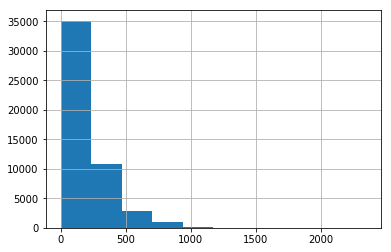

count    50000.000000
mean       218.277440
std        161.551621
min          2.000000
25%        120.000000
50%        164.000000
75%        264.000000
max       2342.000000
dtype: float64

In [42]:
# Analysing lenght of reviews after all preprocessing
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

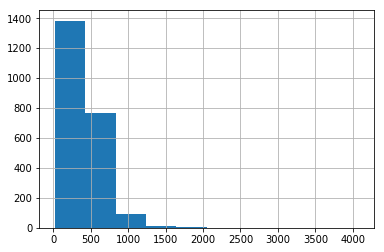

count    2275.000000
mean      437.809231
std       258.011431
min        21.000000
25%       284.000000
50%       376.000000
75%       522.500000
max      4082.000000
dtype: float64

In [43]:
es_reviews_len = [len(x) for x in es_reviews_int]
pd.Series(es_reviews_len).hist()
plt.show()
pd.Series(es_reviews_len).describe()

## Outlier

In [0]:
# remove outliers  : empty reviews
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
labels = [ labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

es_reviews_int = [ es_reviews_int[i] for i, l in enumerate(es_reviews_len) if l>0 ]
es_labels = [ es_labels[i] for i, l in enumerate(es_reviews_len) if l> 0 ]

## Padding

In [0]:
# Set reviews to seq_lenght
# truncate or padd with zeroes
def pad_features(reviews_int, seq_length):
  
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    index_trunc = []
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
            index_trunc.append(i)
        
        features[i,:] = np.array(new)
    
    return features, index_trunc

In [0]:
# adjust all reviews to a length of 300 words
len_feat = 300
features, ind_trunc = pad_features(reviews_int, len_feat)
es_features, es_ind_trunc = pad_features(es_reviews_int, len_feat)

In [0]:
# shuffle all english reviews at random
feature_s = features.copy()
labels_s = labels.copy()

labels_a = np.array(labels)
indices = np.arange(features.shape[0])
np.random.shuffle(indices)

features = features[indices]
labels = labels_a[indices]

In [0]:
# shuffle all spanish reviews at random
es_feature_s = es_features.copy()
es_labels_s = es_labels.copy()

es_labels_a = np.array(es_labels)
es_indices = np.arange(es_features.shape[0])
np.random.shuffle(es_indices)

es_features = es_features[es_indices]
es_labels = es_labels_a[es_indices]

In [0]:
# split the datasets into training, testing and validation tests
split_frac = 0.8

train_x = features[0:int(split_frac*len(features))]
train_y = labels[0:int(split_frac*len(features))]

remaining_x = features[int(split_frac*len(features)):]
remaining_y = labels[int(split_frac*len(features)):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [50]:
# check if the final sets are still balanced
y = np.bincount(test_y)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0, 2495],
       [   1, 2505]])

# Model

In [51]:
# define model
model = Sequential()
e = Embedding(ordered_emb.shape[0], ordered_emb.shape[1], weights=[ordered_emb], input_length=len_feat, trainable=False)
model.add(e)
model.add(LSTM(50, dropout = 0.6))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

W0726 16:08:18.134419 139668816545664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 16:08:18.155620 139668816545664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 16:08:18.158582 139668816545664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 16:08:18.169813 139668816545664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 16:08:18.170989 1396688165

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          10722300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,792,551
Trainable params: 70,251
Non-trainable params: 10,722,300
_________________________________________________________________
None


In [0]:
# function to plot the metrics 
def plot(history, nb_epochs):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    first_epoch = 0
    epochs = range(first_epoch + 1, nb_epochs + 1)

    plt.plot(epochs, loss_values[first_epoch:], 'b', label='Training loss')
    plt.plot(epochs, val_loss_values[first_epoch:], 'r', label='Validation loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show(block=False);

    plt.clf()
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc_values[first_epoch:], 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc_values[first_epoch:], 'r', label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show(block=False);

In [0]:
nb_epochs = 10
# history = model.fit(train_x, train_y, batch_size = 32, epochs=nb_epochs, validation_data=(valid_x, valid_y), verbose=1)

In [0]:
model.load_weights(PATH_WEIGHTS)

In [0]:
# plot(history, nb_epochs)

In [56]:
loss, accuracy = model.evaluate(test_x, test_y, verbose=1)
print('Accuracy on english reviews: %f' % (accuracy*100))

5000/5000 [==============================] - 25s 5ms/step
Accuracy on english reviews: 86.860000


In [57]:
loss, accuracy = model.evaluate(es_features, es_labels, verbose=1)
print('Accuracy on spanish reviews: %f' % (accuracy*100))

2275/2275 [==============================] - 11s 5ms/step
Accuracy on spanish reviews: 72.439560


# Error_Analysis


In [0]:
# function to compute the confusion matrix
def stats(model, x_train, y_train):
  y_predict = model.predict(x_train)
  l_pred = [round(x[0]) for x in list(y_predict)]
  tp = [i for i, val in enumerate(l_pred) if val == y_train[i] and val]
  tn = [i for i, val in enumerate(l_pred) if val == y_train[i] and not val]
  fp = [i for i, val in enumerate(l_pred) if val != y_train[i] and val]
  fn = [i for i, val in enumerate(l_pred) if val != y_train[i] and not val]
  TP, TN, FP, FN = len(tp), len(tn), len(fp), len(fn)
  accuracy = (TP + TN)/(TP + TN + FP + FN)
  F1_score = 2*TP / (2*TP + FP + FN + keras.backend.epsilon())
  return tp,tn,fn,fp,accuracy, F1_score

In [59]:
tp,tn,fn,fp,accuracy, F1 = stats(model, test_x, test_y)
print(accuracy)
print(F1)

0.8686
0.8657814095839473


In [60]:
tp,tn,fn,fp,accuracy, F1 = stats(model, es_features, es_labels)
print(accuracy)
print(F1)

0.7243956043956044
0.7502986857526763


In [61]:
print(len(tp))
print(len(tn))
print(len(fp))
print(len(fn))

942
706
424
203


In [62]:
print("average number of unknown char by review")
avg_tn = 0
for i in tn :
  avg_tn += l_spanish_char[i]
print("tn : ",avg_tn/len(tn))
avg_tp = 0
for i in tp :
  avg_tp += l_spanish_char[i]
print("tp : ",avg_tp/len(tp))
avg_fp = 0
for i in fp :
  avg_fp += l_spanish_char[i]
print("fp : ",avg_fp/len(fp))
avg_fn = 0
for i in fn :
  avg_fn += l_spanish_char[i]
print("fn : ",avg_fn/len(fn))

average number of unknown char by review
tn :  50.82011331444759
tp :  49.85774946921444
fp :  50.16509433962264
fn :  51.172413793103445


In [65]:
print("average percent of truncated review")
avg_tn = 0
for i in tn :
  if i in es_ind_trunc:
    avg_tn += 1
avg_tp = 0
for i in tp :
  if i in es_ind_trunc:
    avg_tp += 1
print("correct predictions : ",(avg_tn/len(es_ind_trunc)*100+avg_tp/len(es_ind_trunc)*100))
avg_fn = 0
for i in fn :
  if i in es_ind_trunc:
    avg_fn += 1
avg_fp = 0
for i in fp :
  if i in es_ind_trunc:
    avg_fp += 1
print("wrong predictions : ",(avg_fn/len(es_ind_trunc)*100+avg_fp/len(es_ind_trunc)*100))

average percent of truncated review
correct predictions :  72.01516108654454
wrong predictions :  27.984838913455462
